In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
df=pd.read_csv('/content/02.csv',delimiter=";",index_col=None, header=0)

In [3]:
df = df.drop([
    'CPU cores',
    'Disk size [GB]',
    'CPU capacity provisioned [MHZ]',
    'Network received throughput [KB/s]',
    'Network transmitted throughput [KB/s]',
    'CPU usage [MHZ]',
    'CPU usage [%]',
    'Disk read throughput [KB/s]',
    'Disk write throughput [KB/s]'
], axis=1)


In [4]:
df['Datetime'] = pd.to_datetime(df['Timestamp'], format='%d.%m.%Y %H:%M:%S')
df=df.drop(['Timestamp'],axis=1)

In [5]:
df.head()

,Memory capacity provisioned [KB],Memory usage [KB],Memory usage [%],Datetime
0,4194304,117021,"2,79",2015-11-05 00:00:00
1,4194304,192519,"4,59",2015-11-05 00:05:00
2,4194304,167353,"3,99",2015-11-05 00:10:00
3,4194304,175741,"4,19",2015-11-05 00:15:00
4,4194304,502897,"11,99",2015-11-05 00:20:00


In [9]:
df['Memory usage [%]'] = df['Memory usage [%]'].str.replace(',', '.').astype(float)
# df['Memory usage [%]'] = df['Memory usage [%]'].str.replace(',', '.').astype(float)
df.head()

,Memory capacity provisioned [KB],Memory usage [KB],Memory usage [%],Datetime
0,4194304,117021,2.79,2015-11-05 00:00:00
1,4194304,192519,4.59,2015-11-05 00:05:00
2,4194304,167353,3.99,2015-11-05 00:10:00
3,4194304,175741,4.19,2015-11-05 00:15:00
4,4194304,502897,11.99,2015-11-05 00:20:00


In [10]:
df['Memory_10_min_before'] = df['Memory usage [%]'].shift(1)
df['Memory_20_min_before'] = df['Memory usage [%]'].shift(2)
df['Memory_30_min_before'] = df['Memory usage [%]'].shift(3)
df['hour']=df['Datetime'].dt.hour
df['dayofweek']=df['Datetime'].dt.dayofweek
df['dayodyear']=df['Datetime'].dt.dayofyear
df=df.drop(['Datetime'],axis=1)
df=df.dropna()
df.head()

,Memory capacity provisioned [KB],Memory usage [KB],Memory usage [%],Memory_10_min_before,Memory_20_min_before,Memory_30_min_before,hour,dayofweek,dayodyear
3,4194304,175741,4.19,3.99,4.59,2.79,0,3,309
4,4194304,502897,11.99,4.19,3.99,4.59,0,3,309
5,4194304,158964,3.79,11.99,4.19,3.99,0,3,309
6,4194304,156028,3.72,3.79,11.99,4.19,0,3,309
7,4194304,293182,6.99,3.72,3.79,11.99,0,3,309


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [13]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]
X_train=train_df.drop(columns=['Memory usage [%]'])
y_train=train_df['Memory usage [%]']
X_test=test_df.drop(columns=['Memory usage [%]'])
y_test=test_df['Memory usage [%]']
# test_df.head()

In [14]:
X_train.head()


,Memory capacity provisioned [KB],Memory usage [KB],Memory_10_min_before,Memory_20_min_before,Memory_30_min_before,hour,dayofweek,dayodyear
3,0.0,0.045004,0.042004,0.051005,0.024002,0,3,309
4,0.0,0.162016,0.045005,0.042004,0.051005,0,3,309
5,0.0,0.039004,0.162016,0.045005,0.042004,0,3,309
6,0.0,0.037954,0.039004,0.162016,0.045005,0,3,309
7,0.0,0.087009,0.037954,0.039004,0.162016,0,3,309


In [15]:
import xgboost as xgb

In [16]:
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_round=50 )

In [17]:
# Clean feature names by removing special characters
X_train.columns = X_train.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace(',', '', regex=False)
X_test.columns = X_test.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace(',', '', regex=False)

# Ensure feature names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Fitting the model
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)


[0]	validation_0-rmse:0.07208	validation_1-rmse:0.06489
[1]	validation_0-rmse:0.05094	validation_1-rmse:0.04581
[2]	validation_0-rmse:0.03612	validation_1-rmse:0.03249
[3]	validation_0-rmse:0.02573	validation_1-rmse:0.02308
[4]	validation_0-rmse:0.01844	validation_1-rmse:0.01677
[5]	validation_0-rmse:0.01333	validation_1-rmse:0.01248
[6]	validation_0-rmse:0.00973	validation_1-rmse:0.00949
[7]	validation_0-rmse:0.00724	validation_1-rmse:0.00755
[8]	validation_0-rmse:0.00550	validation_1-rmse:0.00702
[9]	validation_0-rmse:0.00430	validation_1-rmse:0.00717
[10]	validation_0-rmse:0.00346	validation_1-rmse:0.00775
[11]	validation_0-rmse:0.00279	validation_1-rmse:0.00786
[12]	validation_0-rmse:0.00237	validation_1-rmse:0.00844
[13]	validation_0-rmse:0.00207	validation_1-rmse:0.00900
[14]	validation_0-rmse:0.00186	validation_1-rmse:0.00949
[15]	validation_0-rmse:0.00167	validation_1-rmse:0.00949
[16]	validation_0-rmse:0.00153	validation_1-rmse:0.00947
[17]	validation_0-rmse:0.00142	validation

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:0.00103	validation_1-rmse:0.01003
[25]	validation_0-rmse:0.00100	validation_1-rmse:0.01016
[26]	validation_0-rmse:0.00099	validation_1-rmse:0.01017
[27]	validation_0-rmse:0.00097	validation_1-rmse:0.01016
[28]	validation_0-rmse:0.00096	validation_1-rmse:0.01017
[29]	validation_0-rmse:0.00093	validation_1-rmse:0.01026
[30]	validation_0-rmse:0.00090	validation_1-rmse:0.01022
[31]	validation_0-rmse:0.00086	validation_1-rmse:0.01024
[32]	validation_0-rmse:0.00085	validation_1-rmse:0.01024
[33]	validation_0-rmse:0.00084	validation_1-rmse:0.01024
[34]	validation_0-rmse:0.00083	validation_1-rmse:0.01024
[35]	validation_0-rmse:0.00081	validation_1-rmse:0.01028
[36]	validation_0-rmse:0.00078	validation_1-rmse:0.01025
[37]	validation_0-rmse:0.00077	validation_1-rmse:0.01025
[38]	validation_0-rmse:0.00077	validation_1-rmse:0.01025
[39]	validation_0-rmse:0.00077	validation_1-rmse:0.01025
[40]	validation_0-rmse:0.00077	validation_1-rmse:0.01025
[41]	validation_0-rmse:0.00077	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [18]:
y_pred=reg.predict(X_test)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
r2 = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

# Print the metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.9874
Mean Absolute Error: 0.0015
Mean Squared Error: 0.0001
Root Mean Squared Error: 0.0102


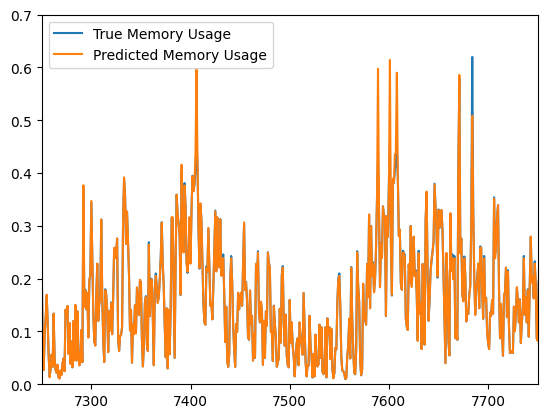

In [55]:
plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:

# Instantiate the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest - R-squared: {r2_rf:.4f}")
print(f"Random Forest - Mean Absolute Error: {mae_rf:.4f}")
print(f"Random Forest - Root Mean Squared Error: {rmse_rf:.4f}")

Random Forest - R-squared: 0.9998
Random Forest - Mean Absolute Error: 0.0001
Random Forest - Root Mean Squared Error: 0.0013


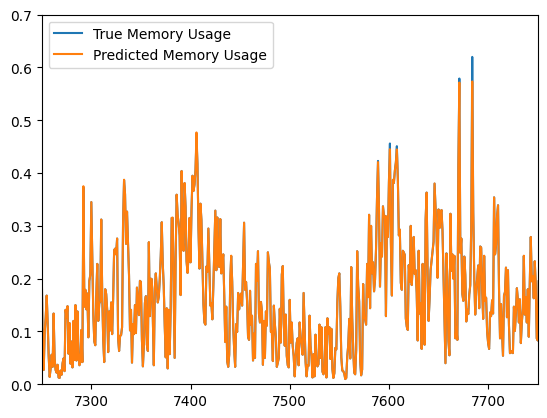

In [54]:
plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_rf, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In [25]:
from sklearn.ensemble import GradientBoostingRegressor


In [26]:

# Instantiate the GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=1000)

# Fit the model
gbr.fit(X_train, y_train)

# Make predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluate the model
r2_gbr = r2_score(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

print(f"Gradient Boosting - R-squared: {r2_gbr:.4f}")
print(f"Gradient Boosting - Mean Absolute Error: {mae_gbr:.4f}")
print(f"Gradient Boosting - Root Mean Squared Error: {rmse_gbr:.4f}")

Gradient Boosting - R-squared: 0.9998
Gradient Boosting - Mean Absolute Error: 0.0003
Gradient Boosting - Root Mean Squared Error: 0.0013


In [27]:
# Evaluate the model
r2_gbr = r2_score(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)

print(f"Gradient Boosting - R-squared: {r2_gbr:.4f}")
print(f"Gradient Boosting - Mean Absolute Error: {mae_gbr:.4f}")
print(f"Gradient Boosting - Root Mean Squared Error: {rmse_gbr:.4f}")

Gradient Boosting - R-squared: 0.9998
Gradient Boosting - Mean Absolute Error: 0.0003
Gradient Boosting - Root Mean Squared Error: 0.0013


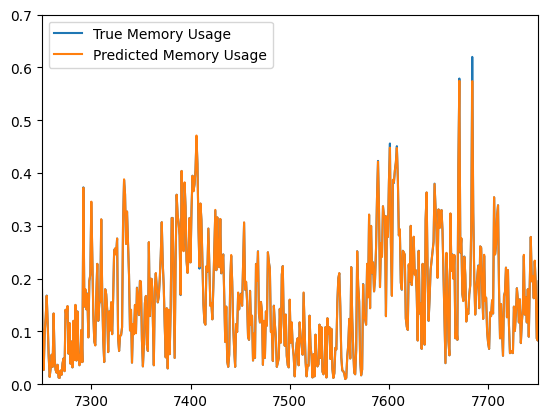

In [59]:
plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_gbr, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()


In [29]:
  from sklearn.neighbors import KNeighborsRegressor

In [30]:
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune the number of neighbors

# Fit the model
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

In [31]:
r2_knn = r2_score(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)

print(f"KNN - R-squared: {r2_knn:.4f}")
print(f"KNN - Mean Absolute Error: {mae_knn:.4f}")
print(f"KNN - Root Mean Squared Error: {rmse_knn:.4f}")

KNN - R-squared: 0.5305
KNN - Mean Absolute Error: 0.0456
KNN - Root Mean Squared Error: 0.0626


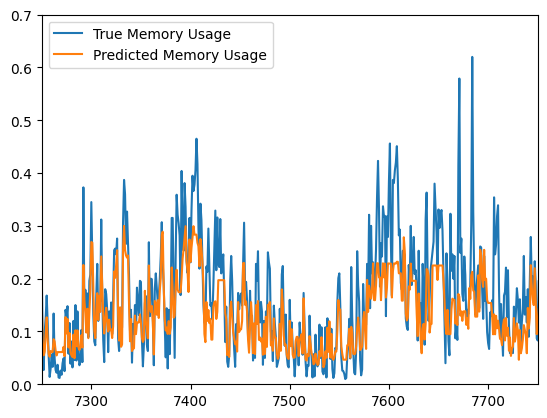

In [60]:
plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_knn, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In [33]:

import lightgbm as lgb

In [34]:
lgb_reg = lgb.LGBMRegressor(n_estimators=1000)

# Fit the model
lgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

# Make predictions
y_pred_lgb = lgb_reg.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 6679, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.116031


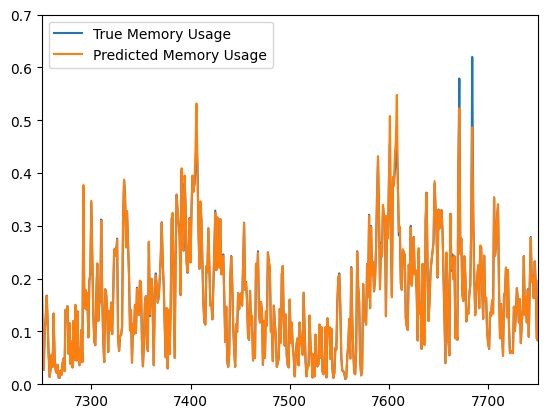

In [61]:
plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_lgb, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor


# Initialize individual models
xgb_model = XGBRegressor(n_estimators=1000)
rf_model = RandomForestRegressor(n_estimators=1000)
gbr_model = GradientBoostingRegressor(n_estimators=1000)
knn_model = KNeighborsRegressor(n_neighbors=5)
lgb_model = LGBMRegressor(n_estimators=1000)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 6679, number of used features: 7
[LightGBM] [Info] Start training from score 0.116031
Voting Regressor - R-squared: 0.9809
Voting Regressor - Mean Absolute Error: 0.0090
Voting Regressor - Root Mean Squared Error: 0.0126


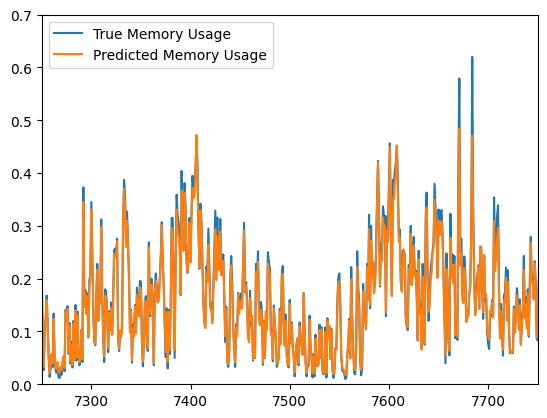

In [62]:
from sklearn.ensemble import VotingRegressor, StackingRegressor
# Create the voting regressor
voting_reg = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('gbr', gbr_model),
    ('knn', knn_model),
    ('lgb', lgb_model)
])

# Train the voting regressor
voting_reg.fit(X_train, y_train)

# Make predictions with the voting regressor
y_pred_voting = voting_reg.predict(X_test)

# Evaluate the voting model
r2_voting = r2_score(y_test, y_pred_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))

print(f"Voting Regressor - R-squared: {r2_voting:.4f}")
print(f"Voting Regressor - Mean Absolute Error: {mae_voting:.4f}")
print(f"Voting Regressor - Root Mean Squared Error: {rmse_voting:.4f}")

plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_voting, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 6679, number of used features: 7
[LightGBM] [Info] Start training from score 0.116031
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 5343, number of used features: 7
[LightGBM] [Info] Start training from score 0.126198
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

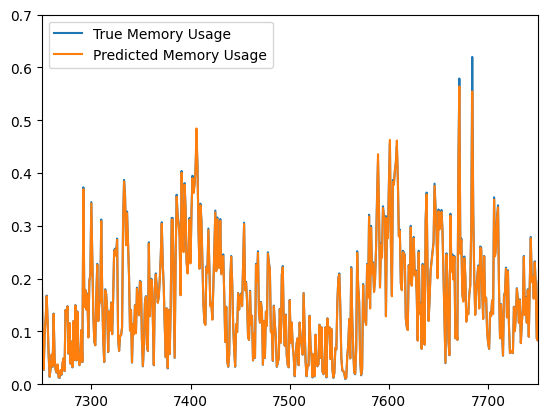

In [63]:
# Create the stacking regressor
stacking_reg = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('gbr', gbr_model),
        ('knn', knn_model),
        ('lgb', lgb_model)
    ],
    final_estimator=Ridge()  # The meta-model (you can use any other regressor)
)

# Train the stacking regressor
stacking_reg.fit(X_train, y_train)

# Make predictions with the stacking regressor
y_pred_stacking = stacking_reg.predict(X_test)

# Evaluate the stacking model
r2_stacking = r2_score(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))

print(f"Stacking Regressor - R-squared: {r2_stacking:.4f}")
print(f"Stacking Regressor - Mean Absolute Error: {mae_stacking:.4f}")
print(f"Stacking Regressor - Root Mean Squared Error: {rmse_stacking:.4f}")

plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_stacking, label='Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()


In [39]:
from sklearn.model_selection import train_test_split

# Split the training data into two parts for blending
X_blend_train, X_blend_meta, y_blend_train, y_blend_meta = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [40]:
# Train the base models on X_blend_train
xgb_model = XGBRegressor(n_estimators=1000)
rf_model = RandomForestRegressor(n_estimators=1000)
gbr_model = GradientBoostingRegressor(n_estimators=1000)
knn_model = KNeighborsRegressor(n_neighbors=5)
lgb_model = LGBMRegressor(n_estimators=1000)

xgb_model.fit(X_blend_train, y_blend_train)
rf_model.fit(X_blend_train, y_blend_train)
gbr_model.fit(X_blend_train, y_blend_train)
knn_model.fit(X_blend_train, y_blend_train)
lgb_model.fit(X_blend_train, y_blend_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 5343, number of used features: 7
[LightGBM] [Info] Start training from score 0.115804


LGBMRegressor(n_estimators=1000)

In [41]:
# Generate meta-features (predictions) for the meta-model using X_blend_meta
meta_features = np.column_stack([
    xgb_model.predict(X_blend_meta),
    rf_model.predict(X_blend_meta),
    gbr_model.predict(X_blend_meta),
    knn_model.predict(X_blend_meta),
    lgb_model.predict(X_blend_meta)
])


In [42]:
from sklearn.linear_model import Ridge

# Train the meta-model on the meta-features
meta_model = Ridge()
meta_model.fit(meta_features, y_blend_meta)


Ridge()

In [43]:
# Generate base model predictions on the test set
meta_features_test = np.column_stack([
    xgb_model.predict(X_test),
    rf_model.predict(X_test),
    gbr_model.predict(X_test),
    knn_model.predict(X_test),
    lgb_model.predict(X_test)
])

# Use the meta-model to make final predictions on the test set
y_pred_blending = meta_model.predict(meta_features_test)


Blending - R-squared: 0.9960
Blending - Mean Absolute Error: 0.0036
Blending - Root Mean Squared Error: 0.0058


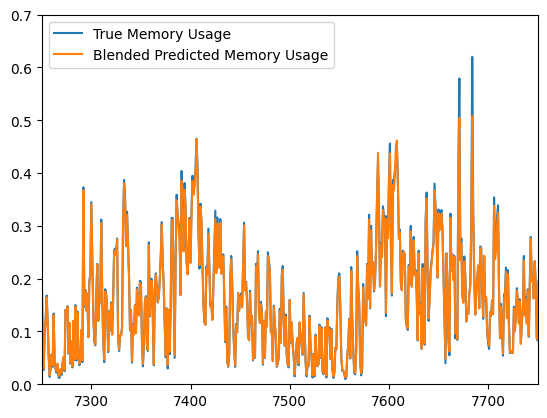

In [64]:
# Evaluate the blending model
r2_blending = r2_score(y_test, y_pred_blending)
mae_blending = mean_absolute_error(y_test, y_pred_blending)
rmse_blending = np.sqrt(mean_squared_error(y_test, y_pred_blending))

print(f"Blending - R-squared: {r2_blending:.4f}")
print(f"Blending - Mean Absolute Error: {mae_blending:.4f}")
print(f"Blending - Root Mean Squared Error: {rmse_blending:.4f}")

plt.plot(y_test.index, y_test, label='True Memory Usage')
plt.plot(y_test.index, y_pred_blending, label='Blended Predicted Memory Usage')
plt.xlim(7250, 7750)
plt.ylim(0, 0.7)
plt.legend()
plt.show()
